# Document Preprocessing and Modeling

## Package Import and Mongo Client

In [3]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import credentials
import time
import string
import config as cfg

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
#!python -m spacy download en_core_web_lg

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

#!pip install pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

class nlp_preprocessor:
            
    def dummy(self,doc):
        return doc
   
    def __init__(self, vectorizer=None, tokenizer=None, cleaning_function=None, 
                 stemmer=None, model=None):
        """
        A class for pipelining our data in NLP problems. The user provides a series of 
        tools, and this class manages all of the training, transforming, and modification
        of the text data.
        ---
        Inputs:
        vectorizer: the model to use for vectorization of text data
        tokenizer: The tokenizer to use, if none defaults to split on spaces
        cleaning_function: how to clean the data, if None, defaults to the in built class
        """
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.default_clean
        if not vectorizer:
            vectorizer = CountVectorizer(tokenizer=self.dummy,preprocessor=self.dummy)
        else:
            vectorizer.tokenizer = self.dummy
            vectorizer.preprocessor = self.dummy
        self.stemmer = stemmer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False

        
    def splitter(self, text):
        """
        Default tokenizer that splits on spaces naively
        """
        return text.split(' ')
        
    def preprocess(self, docs, tokenizer,stemmer,cleaning_function):
        """
        A naive function to lowercase all works can clean them quickly.
        This is the default behavior if no other cleaning function is specified
        """
        cleaned_docs = []
        for doc in docs:
            cleaned_tokens = []
            for token in tokenizer(doc):
                token_word_list = []
                for word in token:
                    clean_word = cleaning_function(word)
                    if stemmer:
                        clean_word = stemmer.stem(clean_word)
                    token_word_list.append(clean_word)
                cleaned_tokens.append(tuple(token_word_list))
            cleaned_docs.append(cleaned_tokens)
        return cleaned_docs
    
    def default_clean(self, word):
        return word.lower()
    
    def clean_text_old(self, text, tokenizer, stemmer):
        """
        A naive function to lowercase all works can clean them quickly.
        This is the default behavior if no other cleaning function is specified
        """
        cleaned_text = []
        for post in text:
            cleaned_words = []
            for word in tokenizer(post):
                low_word = word.lower()
                if stemmer:
                    low_word = stemmer.stem(low_word)
                cleaned_words.append(low_word)
            cleaned_text.append(' '.join(cleaned_words))
        return cleaned_text
    
    def fit(self, docs):
        """
        Cleans the data and then fits the vectorizer with
        the user provided text
        """
        clean_text = self.preprocess(docs, self.tokenizer, self.stemmer,self.cleaning_function)
        self.vectorizer.fit(clean_text)
        self._is_fit = True
        
    def transform(self, docs):
        """
        Cleans any provided data and then transforms the data into
        a vectorized format based on the fit function. Returns the
        vectorized form of the data.
        """
        if not self._is_fit:
            raise ValueError("Must fit the models before transforming!")
        clean_text = self.preprocess(docs, self.tokenizer, self.stemmer,self.cleaning_function)
        return self.vectorizer.transform(clean_text)

## Dataset Pulldown

In [138]:
client = MongoClient(**cfg.config)

db = client.youtube

In [135]:
def get_caption_block(videoID):
    try:
        return db.captions.find_one({'videoID' : videoID},{'_id' : 0, 'caption_block' : 1})['caption_block']
    except:
        return None

def get_rec_vids(collection,filter_dict={}):
    pipeline = [
        {'$unwind': '$videos'}, 
        {'$match': filter_dict},
        {'$project': {'_id': 0, 'query' : 1,'parent':1, 'order' : '$videos.order', 'videoID' : '$videos.videoID'}}
    ]
    
    vid_df = pd.DataFrame(list(collection.aggregate(pipeline)))
    vid_df['caption'] = vid_df['videoID'].apply(get_caption_block)
    caption_series = vid_df['caption']
    caption_series.index = list(vid_df['videoID'])
    caption_series = caption_series.dropna().drop_duplicates()

    return vid_df, caption_series

In [112]:
pd.read_csv('request_log.csv')

,requestID,query,max_results,request_status,datetime,max_rec
0,da23078c-bf88-4024-91e9-d6cc6df4353a,global warming,50,202,"Sat, 17 Aug 2019 18:25:00 GMT",NaN
1,f211c3a5-9ffc-4cd1-a700-6448aae3f589,gun rights,50,202,"Sat, 17 Aug 2019 18:25:03 GMT",NaN
2,fd4189b0-8c3b-4821-a5cc-59fee424c73e,donald trump rally,50,202,"Sat, 17 Aug 2019 18:25:49 GMT",NaN
3,f3af736f-91ea-46a6-88ff-7e44f206e5d2,abortion pro life,50,202,"Sat, 17 Aug 2019 18:26:16 GMT",NaN
4,459bdd9e-41b0-44d9-a830-68e39e343a6d,global warming,50,202,"Tue, 20 Aug 2019 20:05:45 GMT",1.0
5,cea3d2e2-aa93-40d8-9c23-008e712a18e7,mass shootings,50,202,"Tue, 20 Aug 2019 20:53:27 GMT",1.0
6,759c13a9-fe38-423b-ab49-f72da297e8f3,abortion,50,202,"Tue, 20 Aug 2019 20:53:55 GMT",1.0
7,334b3ff3-e95e-4588-a531-b39664f96384,china hong kong,50,202,"Tue, 20 Aug 2019 20:56:54 GMT",1.0
8,8f2c9b0c-56a5-4a3a-af78-6b8e6430b8d2,china hong kong,50,202,"Thu, 22 Aug 2019 18:52:19 GMT",1.0


In [136]:
filter_query = {'requestID' : 'fd4189b0-8c3b-4821-a5cc-59fee424c73e'}

In [139]:
live_meta , live_captions = get_rec_vids(db.recommendations,filter_query)

In [216]:
def selected_topics(model, vectorizer, top_n=10):
    topic_list = []
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
        topic_list.append([(vectorizer.get_feature_names()[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
    return topic_list

In [123]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
stopwords.extend([
    'she',
    'he',
    'her',
    'him',
    'thing',
    'music',
    'were',
    'their'
])

In [124]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w).lower() for w in analyzer(doc) if w not in stopwords)

nlp = CountVectorizer(min_df=0.1,
                      max_df=0.9,
                      tokenizer=TreebankWordTokenizer().tokenize,
                      analyzer=stemmed_words,
                      stop_words=stopwords,
                      token_pattern=r'\b[^\d\W]+\b')

In [125]:
nlp.fit(live_captions)
data_vectorized = nlp.transform(live_captions)

In [126]:
lda = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='batch',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [217]:
topic_words = selected_topics(lda,nlp,top_n=20)

Topic 0:
['think', 'market', 'know', 'look', 'see', 'realli', 'year', 'mean', 'right', 'rate', 'economi', 'us', 'well', 'dollar', 'talk', 'much', 'china', 'presid', 'bank', 'fed']
Topic 1:
['report', 'case', 'laughter', 'law', 'peopl', 'immigr', 'prison', 'know', 'polic', 'new', 'court', 'said', 'also', 'famili', 'legal', 'would', 'year', 'investig', 'week', 'crime']
Topic 2:
['bodi', 'mind', 'everi', 'day', 'health', 'love', 'cell', 'happi', 'live', 'feel', 'flow', 'becom', 'abil', 'environ', 'perfect', 'spirit', 'thank', 'breath', 'take', 'audienc']
Topic 3:
['know', 'peopl', 'think', 'say', 'well', 'realli', 'way', 'thing', 'right', 'someth', 'make', 'mean', 'kind', 'would', 'tri', 'see', 'good', 'could', 'happen', 'time']
Topic 4:
['compani', 'comput', 'buy', 'best', 'job', 'product', 'appl', 'devic', 'store', 'technolog', 'billion', 'dollar', 'audienc', 'year', 'movi', 'sale', 'busi', 'sell', 'servic', 'time']
Topic 5:
['peopl', 'want', 'know', 'said', 'great', 'countri', 'say', '

In [222]:
topic_word_df = pd.DataFrame(topic_words).transpose()
topic_word_df.columns = [f'Topic {x}' for x in range(0,20)]

In [224]:
topic_word_df.to_csv('topic_words.csv')

In [132]:
topics = pd.DataFrame(data_lda)
topics.index = live_captions.index

In [142]:
meta_topics = pd.merge(live_meta,topics,how='left',left_on='videoID',right_index=True)

In [147]:
order_avg = meta_topics.groupby(['order']).mean()

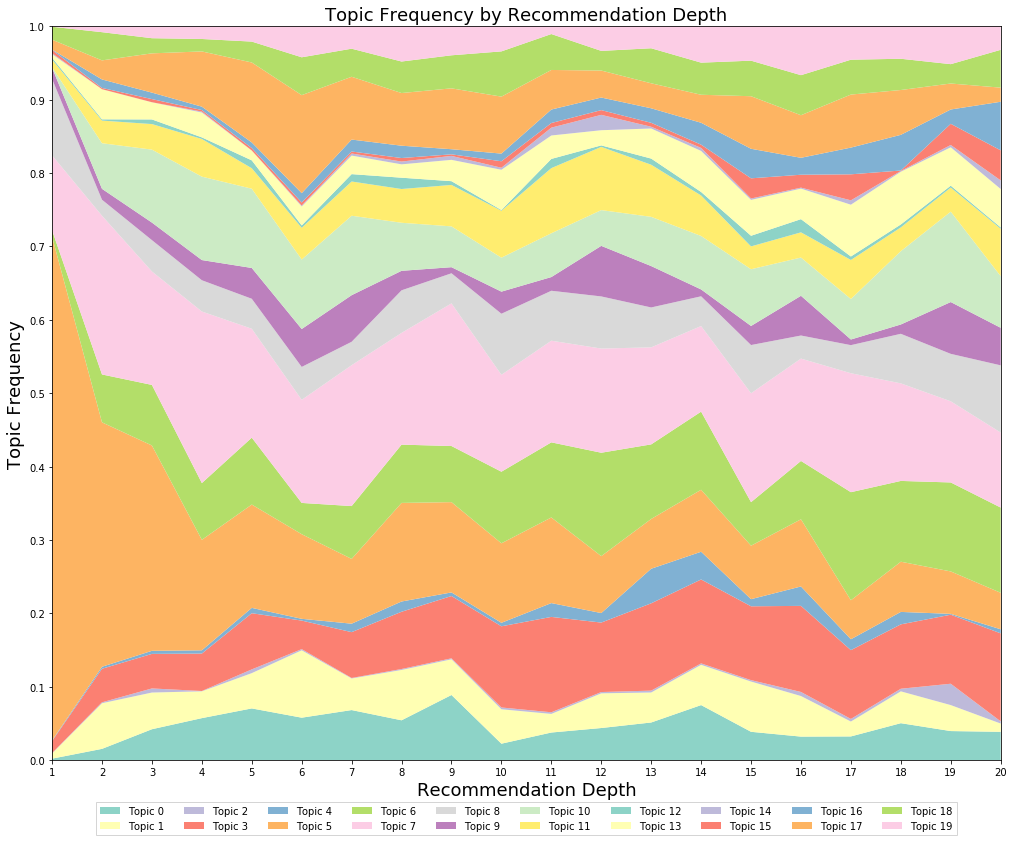

In [211]:
# library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
# Data
x=range(1,21)
y=np.array([x[1] for x in order_avg.iterrows()]).transpose()
 
# Plot
fig, ax = plt.subplots(figsize=(17, 15))

pal = sns.color_palette("Set3")

ax.stackplot(x,y,labels=[f'Topic {x}' for x in range(0,20)],colors=pal)
ax.legend(loc='upper left')
ax.set_xticks(np.arange(1, 21, 1))
ax.set_yticks(np.arange(0, 1.1, .1))
plt.margins(0,0)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=False, shadow=False, ncol=10)

ax.set_title('Topic Frequency by Recommendation Depth',fontsize=18)
plt.xlabel('Recommendation Depth', fontsize=18)
plt.ylabel('Topic Frequency', fontsize=18)

plt.show()


In [173]:
[f'Topic {x}' for x in range(0,20)]

['Topic 0',
 'Topic 1',
 'Topic 2',
 'Topic 3',
 'Topic 4',
 'Topic 5',
 'Topic 6',
 'Topic 7',
 'Topic 8',
 'Topic 9',
 'Topic 10',
 'Topic 11',
 'Topic 12',
 'Topic 13',
 'Topic 14',
 'Topic 15',
 'Topic 16',
 'Topic 17',
 'Topic 18',
 'Topic 19']

ValueError: operands could not be broadcast together with shapes (2,) (3,) 

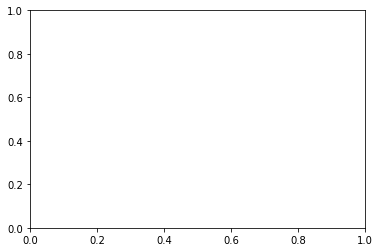

In [165]:
# library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
# Data
x=range(0,2)
y=[[1,2,3],[1,1,1]]

 
# Plot
plt.stackplot(x,y)
plt.legend(loc='upper left')
plt.show()
